
# Лабораторная работа: Линейная и гребневая регрессия, мультиколлинеарность и PCA


In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Настройки отображения
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")


In [2]:

# Загрузка датасета (файл должен лежать в той же папке, что и ноутбук)
df = pd.read_csv("Student_Marks.csv")
df.head()


,number_courses,time_study,Marks
0,3,4.508,19.202
1,4,0.096,7.734
2,4,3.133,13.811
3,6,7.909,53.018
4,8,7.811,55.299


## 1. Первичный анализ данных

In [3]:

# Общая информация о данных
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   number_courses  100 non-null    int64  
 1   time_study      100 non-null    float64
 2   Marks           100 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


In [4]:

# Описательная статистика числовых признаков
df.describe()


,number_courses,time_study,Marks
count,100.000000,100.000000,100.000000
mean,5.290000,4.077140,24.417690
std,1.799523,2.372914,14.326199
min,3.000000,0.096000,5.609000
25%,4.000000,2.058500,12.633000
50%,5.000000,4.022000,20.059500
75%,7.000000,6.179250,36.676250
max,8.000000,7.957000,55.299000


In [5]:

# Проверка пропусков
df.isna().sum()


number_courses    0
time_study        0
Marks             0
dtype: int64

### 1.1. Визуализация распределения признаков и целевой переменной

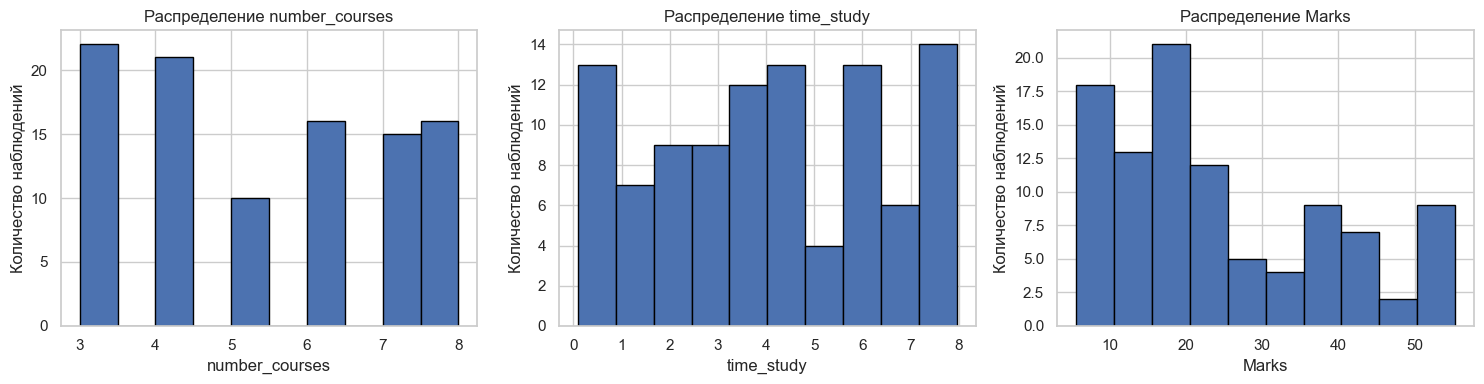

In [6]:

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df['number_courses'], bins=10, edgecolor='black')
axes[0].set_title('Распределение number_courses')
axes[0].set_xlabel('number_courses')
axes[0].set_ylabel('Количество наблюдений')

axes[1].hist(df['time_study'], bins=10, edgecolor='black')
axes[1].set_title('Распределение time_study')
axes[1].set_xlabel('time_study')
axes[1].set_ylabel('Количество наблюдений')

axes[2].hist(df['Marks'], bins=10, edgecolor='black')
axes[2].set_title('Распределение Marks')
axes[2].set_xlabel('Marks')
axes[2].set_ylabel('Количество наблюдений')

plt.tight_layout()
plt.show()


## 2. Корреляционный анализ и мультиколлинеарность

In [7]:

# Корреляционная матрица
corr = df.corr(numeric_only=True)
corr


,number_courses,time_study,Marks
number_courses,1.000000,0.204844,0.417335
time_study,0.204844,1.000000,0.942254
Marks,0.417335,0.942254,1.000000


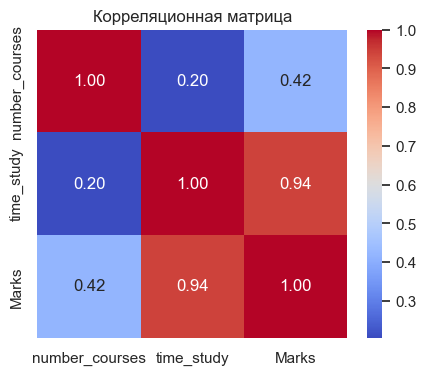

In [8]:

# Визуализация корреляционной матрицы
plt.figure(figsize=(5, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица")
plt.show()


In [9]:

# Расчёт VIF для признаков
X_vif = df[['number_courses', 'time_study']]

# Добавляем константу для корректного расчёта VIF
X_with_const = np.column_stack([np.ones(len(X_vif)), X_vif.values])

vif_values = []
feature_names = ['number_courses', 'time_study']

for i in range(1, X_with_const.shape[1]):  # пропускаем константу (0-й столбец)
    vif = variance_inflation_factor(X_with_const, i)
    vif_values.append(vif)

for name, v in zip(feature_names, vif_values):
    print(f"VIF для {name}: {v:.3f}")


VIF для number_courses: 1.044
VIF для time_study: 1.044


## 3. Построение моделей линейной и гребневой регрессии

In [10]:

# Признаки и целевая переменная
X = df[['number_courses', 'time_study']]
y = df['Marks']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((80, 2), (20, 2))

### 3.1. Линейная регрессия

In [ ]:

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred_lin = linreg.predict(X_test)

# RMSE считаем вручную через корень из MSE
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred_lin))
r2_lin = r2_score(y_test, y_pred_lin)
mape_lin = mean_absolute_percentage_error(y_test, y_pred_lin)

print("Линейная регрессия (test):")
print(f"  RMSE = {rmse_lin:.3f}")
print(f"  R²   = {r2_lin:.3f}")
print(f"  MAPE = {mape_lin:.3f}")


Линейная регрессия (test):
  RMSE = 3.768
  R²   = 0.946
  MAPE = 0.113


### 3.2. Гребневая (Ridge) регрессия

In [12]:

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

y_pred_ridge = ridge.predict(X_test_scaled)

rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)
mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge)

print("Ridge-регрессия (test):")
print(f"  RMSE = {rmse_ridge:.3f}")
print(f"  R²   = {r2_ridge:.3f}")
print(f"  MAPE = {mape_ridge:.3f}")


Ridge-регрессия (test):
  RMSE = 3.880
  R²   = 0.943
  MAPE = 0.118


### 3.3. Кросс-валидация моделей

In [13]:

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Линейная регрессия
rmse_cv_lin = -cross_val_score(
    LinearRegression(), X, y,
    cv=cv, scoring='neg_root_mean_squared_error'
)
r2_cv_lin = cross_val_score(
    LinearRegression(), X, y,
    cv=cv, scoring='r2'
)
mape_cv_lin = -cross_val_score(
    LinearRegression(), X, y,
    cv=cv, scoring='neg_mean_absolute_percentage_error'
)

print("CV (Linear Regression):")
print(f"  RMSE mean = {rmse_cv_lin.mean():.3f}")
print(f"  R²   mean = {r2_cv_lin.mean():.3f}")
print(f"  MAPE mean = {mape_cv_lin.mean():.3f}")

from sklearn.pipeline import make_pipeline

# Ridge с масштабированием через Pipeline
ridge_pipe = make_pipeline(StandardScaler(), Ridge(alpha=1.0))

rmse_cv_ridge = -cross_val_score(
    ridge_pipe, X, y,
    cv=cv, scoring='neg_root_mean_squared_error'
)
r2_cv_ridge = cross_val_score(
    ridge_pipe, X, y,
    cv=cv, scoring='r2'
)
mape_cv_ridge = -cross_val_score(
    ridge_pipe, X, y,
    cv=cv, scoring='neg_mean_absolute_percentage_error'
)

print("\nCV (Ridge Regression):")
print(f"  RMSE mean = {rmse_cv_ridge.mean():.3f}")
print(f"  R²   mean = {r2_cv_ridge.mean():.3f}")
print(f"  MAPE mean = {mape_cv_ridge.mean():.3f}")


CV (Linear Regression):
  RMSE mean = 3.687
  R²   mean = 0.921
  MAPE mean = 0.197

CV (Ridge Regression):
  RMSE mean = 3.689
  R²   mean = 0.921
  MAPE mean = 0.193


## 4. PCA: уменьшение размерности и модели на главных компонентах

In [ ]:

# Стандартизация исходных признаков
scaler_pca = StandardScaler()
X_scaled = scaler_pca.fit_transform(X)

# PCA с двумя компонентами
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

print("Доля объяснённой дисперсии компонентами:", pca.explained_variance_ratio_)
print("Суммарная доля объяснённой дисперсии:", pca.explained_variance_ratio_.sum())


Доля объяснённой дисперсии компонентами: [0.60242192 0.39757808]
Суммарная доля объяснённой дисперсии: 1.0


In [ ]:

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_pca, y, test_size=0.2, random_state=42
)

X_train_p.shape, X_test_p.shape


((80, 2), (20, 2))

### 4.1. Линейная регрессия на PCA-признаках

In [16]:

linreg_p = LinearRegression()
linreg_p.fit(X_train_p, y_train_p)

y_pred_lin_p = linreg_p.predict(X_test_p)

rmse_lin_p = np.sqrt(mean_squared_error(y_test_p, y_pred_lin_p))
r2_lin_p = r2_score(y_test_p, y_pred_lin_p)
mape_lin_p = mean_absolute_percentage_error(y_test_p, y_pred_lin_p)

print("Линейная регрессия на PCA-признаках (test):")
print(f"  RMSE = {rmse_lin_p:.3f}")
print(f"  R²   = {r2_lin_p:.3f}")
print(f"  MAPE = {mape_lin_p:.3f}")


Линейная регрессия на PCA-признаках (test):
  RMSE = 3.768
  R²   = 0.946
  MAPE = 0.113


### 4.2. Ridge-регрессия на PCA-признаках

In [17]:

ridge_p = Ridge(alpha=1.0)
ridge_p.fit(X_train_p, y_train_p)

y_pred_ridge_p = ridge_p.predict(X_test_p)

rmse_ridge_p = np.sqrt(mean_squared_error(y_test_p, y_pred_ridge_p))
r2_ridge_p = r2_score(y_test_p, y_pred_ridge_p)
mape_ridge_p = mean_absolute_percentage_error(y_test_p, y_pred_ridge_p)

print("Ridge-регрессия на PCA-признаках (test):")
print(f"  RMSE = {rmse_ridge_p:.3f}")
print(f"  R²   = {r2_ridge_p:.3f}")
print(f"  MAPE = {mape_ridge_p:.3f}")


Ridge-регрессия на PCA-признаках (test):
  RMSE = 3.880
  R²   = 0.943
  MAPE = 0.118


## 5. Сравнение моделей и выводы

In [18]:

import pandas as pd

results = pd.DataFrame({
    'Модель': [
        'Linear (исходные признаки)',
        'Ridge (исходные признаки)',
        'Linear (PCA)',
        'Ridge (PCA)'
    ],
    'RMSE': [rmse_lin, rmse_ridge, rmse_lin_p, rmse_ridge_p],
    'R²': [r2_lin, r2_ridge, r2_lin_p, r2_ridge_p],
    'MAPE': [mape_lin, mape_ridge, mape_lin_p, mape_ridge_p]
})

results


,Модель,RMSE,R²,MAPE
0,Linear (исходные признаки),3.768385,0.945994,0.112771
1,Ridge (исходные признаки),3.879675,0.942757,0.118070
2,Linear (PCA),3.768385,0.945994,0.112771
3,Ridge (PCA),3.880104,0.942744,0.118091



### Вопросики

1. **Качество линейной и гребневой регрессии на исходных признаках**  
   Модели демонстрируют высокий коэффициент детерминации (R²) и относительно небольшие значения RMSE и MAPE. Это говорит о хорошей аппроксимирующей способности линейной модели на данном наборе данных.

2. **Мультиколлинеарность**  
   Значения VIF для признаков `number_courses` и `time_study` близки к 1, что указывает на отсутствие серьёзной мультиколлинеарности. Поэтому использование гребневой регрессии не даёт существенного выигрыша по качеству по сравнению с обычной линейной регрессией.

3. **PCA и модели на главных компонентах**  
   Поскольку исходных признаков всего два, PCA лишь выполняет поворот пространства признаков, не уменьшая размерности. В результате метрики качества моделей на главных компонентах очень близки к метрикам моделей на исходных признаках.

4. **Общий вывод**  
   Для рассматриваемого датасета простая линейная регрессия уже даёт хорошее качество. Методы регуляризации (Ridge) и уменьшения размерности (PCA) не приводят к существенному улучшению качества, но являются важными инструментами при работе с более сложными и многомерными данными.
